## **드라이브 마운트**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/Classification

#%cd /content/drive/MyDrive/Classification_balanced_128

%cd /content/drive/MyDrive/Classification_balanced_256

/content/drive/MyDrive/Classification_balanced_256


## **필요 라이브러리 설치**

In [ ]:
!pip install tensorflow-addons==0.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2
import numpy as np

from model_layer import * #모듈화한 모델 import
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

import keras.backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## **Train, Validation, Test 데이터셋**

In [ ]:
os.makedirs('checkpoints', exist_ok=True)

test1 = 0
test2 = 1
test3 = 2
test4 = 3
test5 = 4
level1=10
level2=20

file_name=[]

train = 0
val = 1
test = 2

def make_test_data(test1,level1, num):
  X=[]
  y=[]

  for f_label, folder_name in enumerate(('ACTINIC_KERATOSIS', 'BASAL_CELL_CARCINOMA', 'DERMATOFIBROMA', 'MELANOMA', 'NEVUS', 'PIGMENTED_BENIGN_KERATOSIS', 'SQUAMOUS_CELL_CARCIMONA','VASCULAR_LESION')):
    folder_path = os.path.join("./dataset_"+str(num)+"/", folder_name)
    print(folder_path)

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if num == test:
          file_name.append(fpath)

        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, image_shape[1:])

        X.append(img)
        y.append(f_label)

  X = np.array(X)
  y = np.array(y).reshape(-1, 1)

  X = (X / 255.)
  X = X.transpose(0, 3, 1, 2)
  X = X.astype(np.float32)
  y = y.astype(np.float32)

  x_train = X
  y_train = y
  return x_train, y_train

#image_shape = (3, 128, 128)
image_shape = (3, 256, 256)

x_train, y_train= make_test_data(test1,level1, train)
x_val, y_val= make_test_data(test1,level1, val)
x_test, y_test= make_test_data(test1,level1, test)

enc = OneHotEncoder(handle_unknown='ignore')
temp_y = enc.fit_transform(y_train).toarray()
y_train = temp_y

temp_y = enc.fit_transform(y_val).toarray()
y_val = temp_y

./dataset_0/ACTINIC_KERATOSIS
./dataset_0/BASAL_CELL_CARCINOMA
./dataset_0/DERMATOFIBROMA
./dataset_0/MELANOMA
./dataset_0/NEVUS
./dataset_0/PIGMENTED_BENIGN_KERATOSIS
./dataset_0/SQUAMOUS_CELL_CARCIMONA
./dataset_0/VASCULAR_LESION
./dataset_1/ACTINIC_KERATOSIS
./dataset_1/BASAL_CELL_CARCINOMA
./dataset_1/DERMATOFIBROMA
./dataset_1/MELANOMA
./dataset_1/NEVUS
./dataset_1/PIGMENTED_BENIGN_KERATOSIS
./dataset_1/SQUAMOUS_CELL_CARCIMONA
./dataset_1/VASCULAR_LESION
./dataset_2/ACTINIC_KERATOSIS
./dataset_2/BASAL_CELL_CARCINOMA
./dataset_2/DERMATOFIBROMA
./dataset_2/MELANOMA
./dataset_2/NEVUS
./dataset_2/PIGMENTED_BENIGN_KERATOSIS
./dataset_2/SQUAMOUS_CELL_CARCIMONA
./dataset_2/VASCULAR_LESION


## **모델 선언**

In [ ]:
#make model
model = make_model(image_shape, num_classes=8)

epochs = 200
ckpoint= tf.keras.callbacks.ModelCheckpoint(filepath='./model_save/',monitor='val_f1_score',save_best_only=True, save_weights_only=True)
earlystopping= tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=10,mode='max')

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()
spec=tf.keras.metrics.SpecificityAtSensitivity(0.5)
iou=tf.keras.metrics.MeanIoU(num_classes=8)
f1_score = tfa.metrics.F1Score(num_classes=8, threshold=0.6,average='micro')

learningrate=0.000007
batch = 4
opt1=tf.keras.optimizers.Adamax(learning_rate=learningrate)
opt3=tf.keras.optimizers.Adam(learning_rate=learningrate)
opt1=tf.keras.mixed_precision.LossScaleOptimizer(opt1)

## **모델 학습**

In [ ]:
losses  = 'mse'
model.compile(
        optimizer = opt1,
        loss = losses,
        metrics = [precision, recall, auc,f1_score,spec,iou]
)

hist = model.fit(x_train, y_train,epochs=epochs,batch_size=batch,validation_data = (x_val, y_val),
        callbacks = [ckpoint]
)

model.save("./model_save/classification256_model_"+str(test1)+"2.h5", include_optimizer=True)

Epoch 1/200
228/228 [==============================] - 29s 110ms/step - loss: 0.1092 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5490 - f1_score: 0.0000e+00 - specificity_at_sensitivity: 0.0691 - mean_io_u: 0.4375 - val_loss: 0.1094 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_mean_io_u: 0.4375
Epoch 2/200
228/228 [==============================] - 24s 106ms/step - loss: 0.1088 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6207 - f1_score: 0.0000e+00 - specificity_at_sensitivity: 0.6395 - mean_io_u: 0.4375 - val_loss: 0.1094 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5150 - val_f1_score: 0.0000e+00 - val_specificity_at_sensitivity: 0.5038 - val_mean_io_u: 0.4375
Epoch 3/200
228/228 [==============================] - 23s 103ms/step - loss: 0.1082 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6528 - f1_score: 0.0000e+00 - specificity_at_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **모델 테스트**

In [ ]:
temp_y = enc.fit_transform(y_test).toarray()
y_test = temp_y

test_metrics = model.evaluate(x_test, y_test)
print("Test Metrics:", test_metrics)
print(hist.history.keys())

4/4 [==============================] - 1s 187ms/step - loss: 0.0904 - precision: 0.6061 - recall: 0.1754 - auc: 0.7940 - f1_score: 0.2676 - specificity_at_sensitivity: 0.9023 - mean_io_u: 0.4375
Test Metrics: [0.09044145047664642, 0.6060606241226196, 0.17543859779834747, 0.7940354943275452, 0.26760563254356384, 0.902255654335022, 0.4375]
dict_keys(['loss', 'precision', 'recall', 'auc', 'f1_score', 'specificity_at_sensitivity', 'mean_io_u', 'val_loss', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score', 'val_specificity_at_sensitivity', 'val_mean_io_u'])


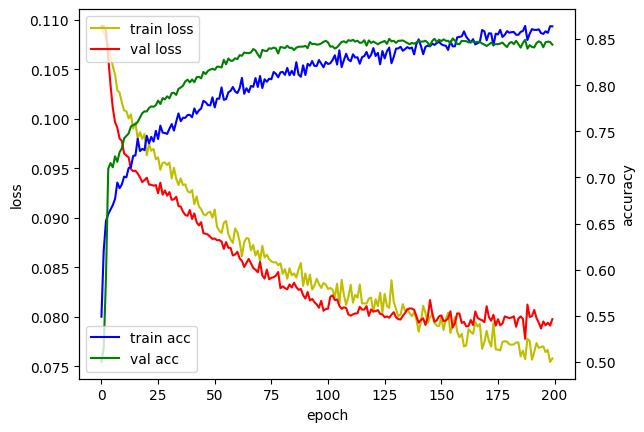

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
acc_ax.plot(hist.history['auc'],'b',label='train acc')
acc_ax.plot(hist.history['val_auc'],'g',label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
print('##### Test Result #####')
print('loss : ',str(test_metrics[0]))
print('Accuracy : ',str(test_metrics[1]))

##### Test Result #####
loss :  0.09044145047664642
Accuracy :  0.6060606241226196
